In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD, Adam
import PIL
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

**Downloading Dataset**

I have uploaded dataset of all images to github to make it easier to work with Colab.

In [ ]:
!wget https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/dataset_reduced.zip?raw=true  -O data.zip
!unzip data.zip
!pip install imgaug
import imgaug as ia

--2020-08-23 13:30:43--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/blob/master/dataset_reduced.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/dataset_reduced.zip [following]
--2020-08-23 13:30:43--  https://github.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/raw/master/dataset_reduced.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/dataset_reduced.zip [following]
--2020-08-23 13:30:43--  https://raw.githubusercontent.com/fk03983/Physiological-Feature-Extraction-using-Thermal-Imaging/master/dataset_reduced.zip
Resolving raw.git

Loading the datasets into the variables

In [ ]:
SIZE_X = int(1024 / 8)
SIZE_Y = int(768 / 8)

x = np.load( "train_images_small.npy")/255
x = x.reshape(2935, SIZE_Y, SIZE_X, 1)
y = np.load('bounding_box_small.npy')
y[:, 0], y[:, 1] = y[:, 0] , y[:,1]
y[:, 2], y[:, 3] = y[:, 2] , y[:,3]

metadeta = pd.read_csv('metadeta.csv')
print(x.shape)
data_size = x.shape[0] #number of images

augmented_meta_deta = {'subj' : [], 'augmented' : []}

(2935, 96, 128, 1)


defining functions to augment the data. Augmenting means to produce more images from the images already in the dataset. More [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/).

The function `translate` takes an image changes the position of the object on the image. Amount of change is choosen randomly from the dataset. We also change the bounding box of the image. We do this so that the model does not assume that all the faces occur at the center of the image.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random



def translate(image, predicted, show = False):
  new_bb = np.copy(predicted)
  start_x = int(predicted[0] * 0.9)
  start_y = int(predicted[2] * 0.9)
  end_x = int(predicted[1] * 0.9)
  end_y = int(predicted[3] * 0.9)

  
  new_x = random.randint(-start_x , SIZE_X - end_x)
  new_y = random.randint(-start_y , SIZE_Y - end_y)

  image = np.reshape(image, (SIZE_Y, SIZE_X))

  translation_matrix = np.float32([ [1,0, new_x], [0,1, new_y] ])
  img_translation = cv2.warpAffine(image, translation_matrix, (SIZE_X, SIZE_Y))

  new_bb[0], new_bb[1] = new_bb[0] + new_x, new_bb[1] + new_x
  new_bb[2], new_bb[3] = new_bb[2] + new_y, new_bb[3] + new_y

  if new_bb[0] > SIZE_X:
    new_bb[0] = SIZE_X
  if new_bb[1] > SIZE_X:
    new_bb[1] = SIZE_X
  if new_bb[2] > SIZE_Y:
    new_bb[2] = SIZE_Y
  if new_bb[3] > SIZE_Y:
    new_bb[3] = SIZE_Y

  if show:
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
    ax[0].imshow(image)
    ax[1].imshow(img_translation)
    rect = patches.Rectangle((predicted[0] ,predicted[2] ),(predicted[1] - predicted[0]) ,(predicted[3] - predicted[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[0].add_patch(rect)


    new_rect = patches.Rectangle((new_bb[0] ,new_bb[2] ),(new_bb[1] - new_bb[0]) ,(new_bb[3] - new_bb[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[1].add_patch(new_rect) 


    plt.show()
  return np.reshape(img_translation, (SIZE_Y, SIZE_X, 1)), new_bb

The  `scale` function zooms in and out of the image, we do this so that the model does not assume that all faces have the same size. 

In [ ]:
def scale(image, predicted, show = False):
  image = np.reshape(image, (SIZE_Y, SIZE_X))
  img_shape = image.shape
  canvas = np.zeros(img_shape, dtype = np.uint8)

  scale = random.uniform(-0.5, 0.5)
  resize_scale_x = 1 + scale
  resize_scale_y = 1 + scale
 
  img=  cv2.resize(image * 255, None, fx = resize_scale_x, fy = resize_scale_y)
  new_bb = predicted * resize_scale_x

  y_lim = int(min(resize_scale_y,1)*img_shape[0])
  x_lim = int(min(resize_scale_x,1)*img_shape[1])

  
  canvas[:y_lim,:x_lim] =  img[:y_lim,:x_lim]

  img = canvas/255

  if new_bb[0] > SIZE_X:
    new_bb[0] = SIZE_X
  if new_bb[1] > SIZE_X:
    new_bb[1] = SIZE_X
  if new_bb[2] > SIZE_Y:
    new_bb[2] = SIZE_Y
  if new_bb[3] > SIZE_Y:
    new_bb[3] = SIZE_Y
  
  if show:
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=[10,10])
    ax[0].imshow(image)
    ax[1].imshow(canvas)
    rect = patches.Rectangle((predicted[0] ,predicted[2] ),(predicted[1] - predicted[0]) ,(predicted[3] - predicted[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[0].add_patch(rect)


    new_rect = patches.Rectangle((new_bb[0] ,new_bb[2] ),(new_bb[1] - new_bb[0]) ,(new_bb[3] - new_bb[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
    ax[1].add_patch(new_rect) 


    plt.show()

  return np.reshape(img, (SIZE_Y, SIZE_X, 1)), new_bb

def advanced_augment(func, img, bb, show):
  new_image = np.zeros((SIZE_Y, SIZE_X, 3))
  to_image  = np.reshape(img, (96, 128))
  new_image[:,:,0] = to_image
  bbs = BoundingBoxesOnImage([
  BoundingBox(x1=bb[0], y1=bb[2], x2=bb[1], y2=bb[3])
  ], shape=new_image.shape)
  #ia.imshow(bbs.draw_on_image(new_image))
  #print(bb)
  img, bb = func(image = new_image, bounding_boxes = bbs)
  #print(bb)
  if show:
    ia.imshow(bb.draw_on_image(img))
  img= np.reshape(img[:,:,0], (96, 128, 1))
  new_bb = bb.bounding_boxes[0].x1, bb.bounding_boxes[0].x2, bb.bounding_boxes[0].y1, bb.bounding_boxes[0].y2
  return img, new_bb


Augments the dataset by adding 4 new images for every image in the dataset. We keep the subject ID preserved. 4 new images are added by randomly decided whether to call `translate` or `scale` function.

In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

augmented_x = np.zeros((data_size * 10, SIZE_Y, SIZE_X, 1))
augmented_y = np.zeros((data_size * 10, 4))

n = 0
for i, row in metadeta.iterrows():
  subj = row['subj']
  augmented_x[n] = x[i]
  augmented_y[n] = y[i]
  n += 1
  for _ in range(9):
    show = False
    prob = random.random()
    if prob < 0.25:
      augmented_x[n], augmented_y[n] = translate(x[i], y[i], show = show)
    elif prob < 0.5:
      rotate = iaa.Affine(rotate = (-15, 15))
      augmented_x[n], augmented_y[n] = advanced_augment(rotate, x[i], y[i], show)
    elif prob < 0.75:
      blur = iaa.GaussianBlur(sigma=(0, 3))
      augmented_x[n], augmented_y[n] = advanced_augment(blur, x[i], y[i], show)
    else:
      augmented_x[n], augmented_y[n] = scale(x[i], y[i], show = show)
    n += 1
  if (n % 100) == 0:
    print(n)
  augmented_meta_deta['subj'].extend([subj] * 10)
  augmented_meta_deta['augmented'].extend([0, 1, 1, 1, 1] + [1 for i in range(5)])






100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

KeyboardInterrupt: ignored

**Dividing dataset into training, validation and test set**
We load the dataset, normalize so that all values are between 0 and 1 and then divide it into train, test and validation set.

The division here is slightly different. Conventionally all the observations are divided into these sets, but here, to ensure that the model is robust and our final test has not been seen, we divide subjects into test, train and validation set. Once the sujbects have been divided, we then put all the images belonging to train subjects in train set. Following similar suite for validation and test set, except that we do not include augmented images as we want out test loss to only include original images.

In [ ]:
def data_for_subjects(subjects, include_augmented = False):
  factor = 1 if not include_augmented else 10
  data = np.zeros((len(subjects) * factor, SIZE_Y, SIZE_X, 1))
  print(data.shape)
  label = np.zeros((len(subjects) * factor, 4))

  if not include_augmented:
    indices = np.logical_and(np.isin(metadeta['subj'], subjects), metadeta['augmented'] == 0)
  else:
    indices = np.isin(metadeta['subj'], subjects)
  
  data = augmented_x[indices]
  print(data.shape)
  label = augmented_y[indices]
  return data, label

def display_random_set(data, labels):
  import matplotlib.pyplot as plt
  import matplotlib.patches as patches
  nrows = 5
  ncols = 10
  n = 0
  irand=(np.random.choice(data.shape[0],nrows)//10) * 10
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[100,100])
  for row in range(nrows):
    for col in range(ncols):
      if col == 0:
        to_image = np.reshape(data[irand[n]], (SIZE_Y, SIZE_X)) * 255
        ax[row,col].imshow(to_image)
      else:
        to_image = np.reshape(data[irand[n] + col], (SIZE_Y, SIZE_X)) * 255
        ax[row,col].imshow(to_image)

      predicted = list(labels[irand[n] + col])
      rect = patches.Rectangle((predicted[0],predicted[2]),(predicted[1] - predicted[0]) ,(predicted[3] - predicted[2]),linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
      ax[row,col].add_patch(rect)
    n += 1
         
  plt.legend()
  plt.show()

**Sample Images from the train set**
Notice the changes for each subject

In [ ]:
metadeta = pd.read_csv('new_augmented_metadeta.csv')
subjects = (list(set(metadeta['subj'])))
n = len(subjects)
train_subjects = np.asarray(np.random.choice(subjects, size = int(n * 0.7), replace = False))
left_subjects = np.asarray(list(set(subjects) - (set(train_subjects))))
valid_subjects = np.asarray(np.random.choice(left_subjects, size = int(len(left_subjects) * 0.5), replace = False))
test_subjects = np.asarray(list(set(left_subjects) - (set(valid_subjects))))
print(train_subjects, train_subjects.shape)
print(test_subjects, test_subjects.shape)
print(valid_subjects, valid_subjects.shape)

train_x, train_y = data_for_subjects(train_subjects, True)
valid_x, valid_y = data_for_subjects(valid_subjects, True)
test_x, test_y = data_for_subjects(test_subjects, False)



[40 15 77  4 88 72 54 23 58 66 27 78 73 33 61 28  6 31  7 79 37 35 67 52
 16 83  5 81 11 85 36 48 90 65 20 10 82 24 46 42 34 84 75 63 64 55  9 76
 91 68 41  1 38 32 62 13 94 50 86  3 26 17] (62,)
[ 2 71  8 44 45 80 18 19 21 53 87 25 92 93] (14,)
[43 12 39 74 51 14 29 30 57 22 70 69 89] (13,)
(620, 96, 128, 1)
(20280, 96, 128, 1)
(130, 96, 128, 1)
(4590, 96, 128, 1)
(14, 96, 128, 1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
augmented_meta_deta.to_csv("/content/drive/My Drive/new_augmented_metadeta.csv")
np.save('/content/drive/My Drive/new_augmented_train_x', train_x)
np.save('/content/drive/My Drive/new_augmented_train_y', train_y)
np.save('/content/drive/My Drive/new_augmented_test_x', test_x)
np.save('/content/drive/My Drive/new_augmented_test_y', test_y)
np.save('/content/drive/My Drive/new_augmented_valid_x', valid_x)
np.save('/content/drive/My Drive/new_augmented_valid_y', valid_y)


NameError: ignored

In [ ]:
SIZE_X = int(1024 / 8)
SIZE_Y = int(768 / 8)

metadeta = pd.read_csv('/content/drive/My Drive/new_augmented_metadeta.csv')
train_x = np.load('/content/drive/My Drive/new_augmented_train_x.npy')
train_y = np.load('/content/drive/My Drive/new_augmented_train_y.npy')
train_y[:,0], train_y[:, 1] = (train_y[:,0] - 5) / SIZE_X, (train_y[:, 1] + 5)/ SIZE_X
train_y[:,2], train_y[:, 3] = (train_y[:,2] - 5) / SIZE_Y, (train_y[:, 3] + 5) / SIZE_Y

valid_x = np.load('/content/drive/My Drive/new_augmented_valid_x.npy')
valid_y = np.load('/content/drive/My Drive/new_augmented_valid_y.npy')
valid_y[:,0], valid_y[:, 1] = (valid_y[:,0] - 5) / SIZE_X, (valid_y[:, 1] + 5)/ SIZE_X
valid_y[:,2], valid_y[:, 3] = (valid_y[:,2] - 5) / SIZE_Y, (valid_y[:, 3] + 5) / SIZE_Y

test_x = np.load('/content/drive/My Drive/new_augmented_test_x.npy')
test_y = np.load('/content/drive/My Drive/new_augmented_test_y.npy')
test_y[:,0], test_y[:, 1] = (test_y[:,0] - 5) / SIZE_X, (test_y[:, 1] + 5)/ SIZE_X
test_y[:,2], test_y[:, 3] = (test_y[:,2] - 5) / SIZE_Y, (test_y[:, 3] + 5) / SIZE_Y


**CNN Model**

Epoch 1/200
161/161 [==============================] - 37s 230ms/step - loss: 0.0680 - val_loss: 0.0358
Epoch 2/200
161/161 [==============================] - 36s 222ms/step - loss: 0.0354 - val_loss: 0.0287
Epoch 3/200
161/161 [==============================] - 36s 223ms/step - loss: 0.0295 - val_loss: 0.0292
Epoch 4/200
161/161 [==============================] - 36s 224ms/step - loss: 0.0266 - val_loss: 0.0249
Epoch 5/200
161/161 [==============================] - 36s 223ms/step - loss: 0.0248 - val_loss: 0.0279
Epoch 6/200
161/161 [==============================] - 36s 223ms/step - loss: 0.0232 - val_loss: 0.0246
Epoch 7/200
161/161 [==============================] - 36s 223ms/step - loss: 0.0217 - val_loss: 0.0233
Epoch 8/200
161/161 [==============================] - 36s 223ms/step - loss: 0.0209 - val_loss: 0.0236
Epoch 9/200
161/161 [==============================] - 36s 223ms/step - loss: 0.0201 - val_loss: 0.0227
Epoch 10/200
161/161 [==============================] - 36s 223m

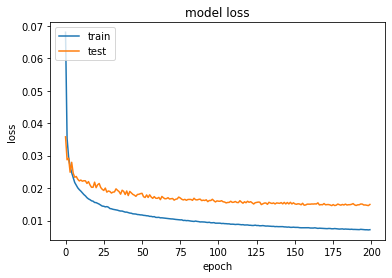

In [ ]:
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

model3 = Sequential()
model3.add(Conv2D(32, (2, 2), padding = 'same', activation='tanh', input_shape=(SIZE_Y, SIZE_X, 1)))

model3.add(Conv2D(32, (2, 2), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
#model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
#model3.add(Dropout(0.5))
model3.add(Conv2D(64, (3, 3), activation='tanh'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='tanh'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(256, (3, 3), activation='tanh'))
model3.add(Conv2D(256, (5, 5), activation='relu'))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
#model3.add(Dropout(0.5))
model3.add(Dense(4, activation='sigmoid'))

sgd = Adam(lr=5e-5)
model3.compile(loss='mean_absolute_error', optimizer=sgd) 
history = model3.fit(train_x, train_y, batch_size=128, epochs=200, validation_data = (valid_x, valid_y), verbose = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

`plot_predictions` prints random 16 images from the dataset.
`intersection_over_union_set` computes intersection over union between predicted bounded box and actual bounding box for all images in the test set. More details [here]('https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/')

In [ ]:
def plot_predictions(predicted_set):
  n = 0
  nrows = 4
  ncols = 4
  irand=np.random.choice(test_y.shape[0],nrows*ncols)
  fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[100,100])
  for row in range(nrows):
    for col in range(ncols):

      to_image = np.reshape(test_x[irand[n]], (SIZE_Y, SIZE_X)) * 255
      ax[row,col].imshow(to_image)

      # Create a Rectangle patch
      predicted = list(predicted_set[irand[n]])
      #print(predicted[0] *SIZE_X, predicted[1] * SIZE_X, predicted[2] * SIZE_Y,predicted[3] * SIZE_Y)
      rect = patches.Rectangle((predicted[0] * SIZE_X,predicted[2] * SIZE_Y),(predicted[1] - predicted[0]) * SIZE_X,(predicted[3] - predicted[2])*SIZE_Y,linewidth=10,edgecolor='r',facecolor='none', label = 'predicted')
      # Add the patch to the Axes
      ax[row,col].add_patch(rect)

      predicted = list(test_y[irand[n]])
      #print(predicted[0] *SIZE_X, predicted[1] * SIZE_X, predicted[2] * SIZE_Y,predicted[3] * SIZE_Y)
      rect = patches.Rectangle((predicted[0] * SIZE_X,predicted[2] * SIZE_Y),(predicted[1] - predicted[0]) * SIZE_X,(predicted[3] - predicted[2])*SIZE_Y,linewidth=10,edgecolor='y',facecolor='none', label = 'actual')
      # Add the patch to the Axes
      ax[row,col].add_patch(rect)
      n += 1
         
  plt.legend()
  plt.show()

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[2], boxB[2])
	xB = min(boxA[1], boxB[1])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[1] - boxA[0] + 1) * (boxA[3] - boxA[2] + 1)
	boxBArea = (boxB[1] - boxB[0] + 1) * (boxB[3] - boxB[2] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def intersection_over_union_set(setA, setB):
  iou = []
  n = setA.shape[0]
  assert setA.shape[0] == setB.shape[0]
  for i in range(n):
    b = bb_intersection_over_union(setA[i], setB[i])
    iou.append(b)

  x = [i * 0.01 for i in range(1, 100)]
  y = [sum([1 for i in iou if i > selected_x])/len(iou) for selected_x in x]
  
  plt.plot(x, y)
  plt.grid()
  plt.show()

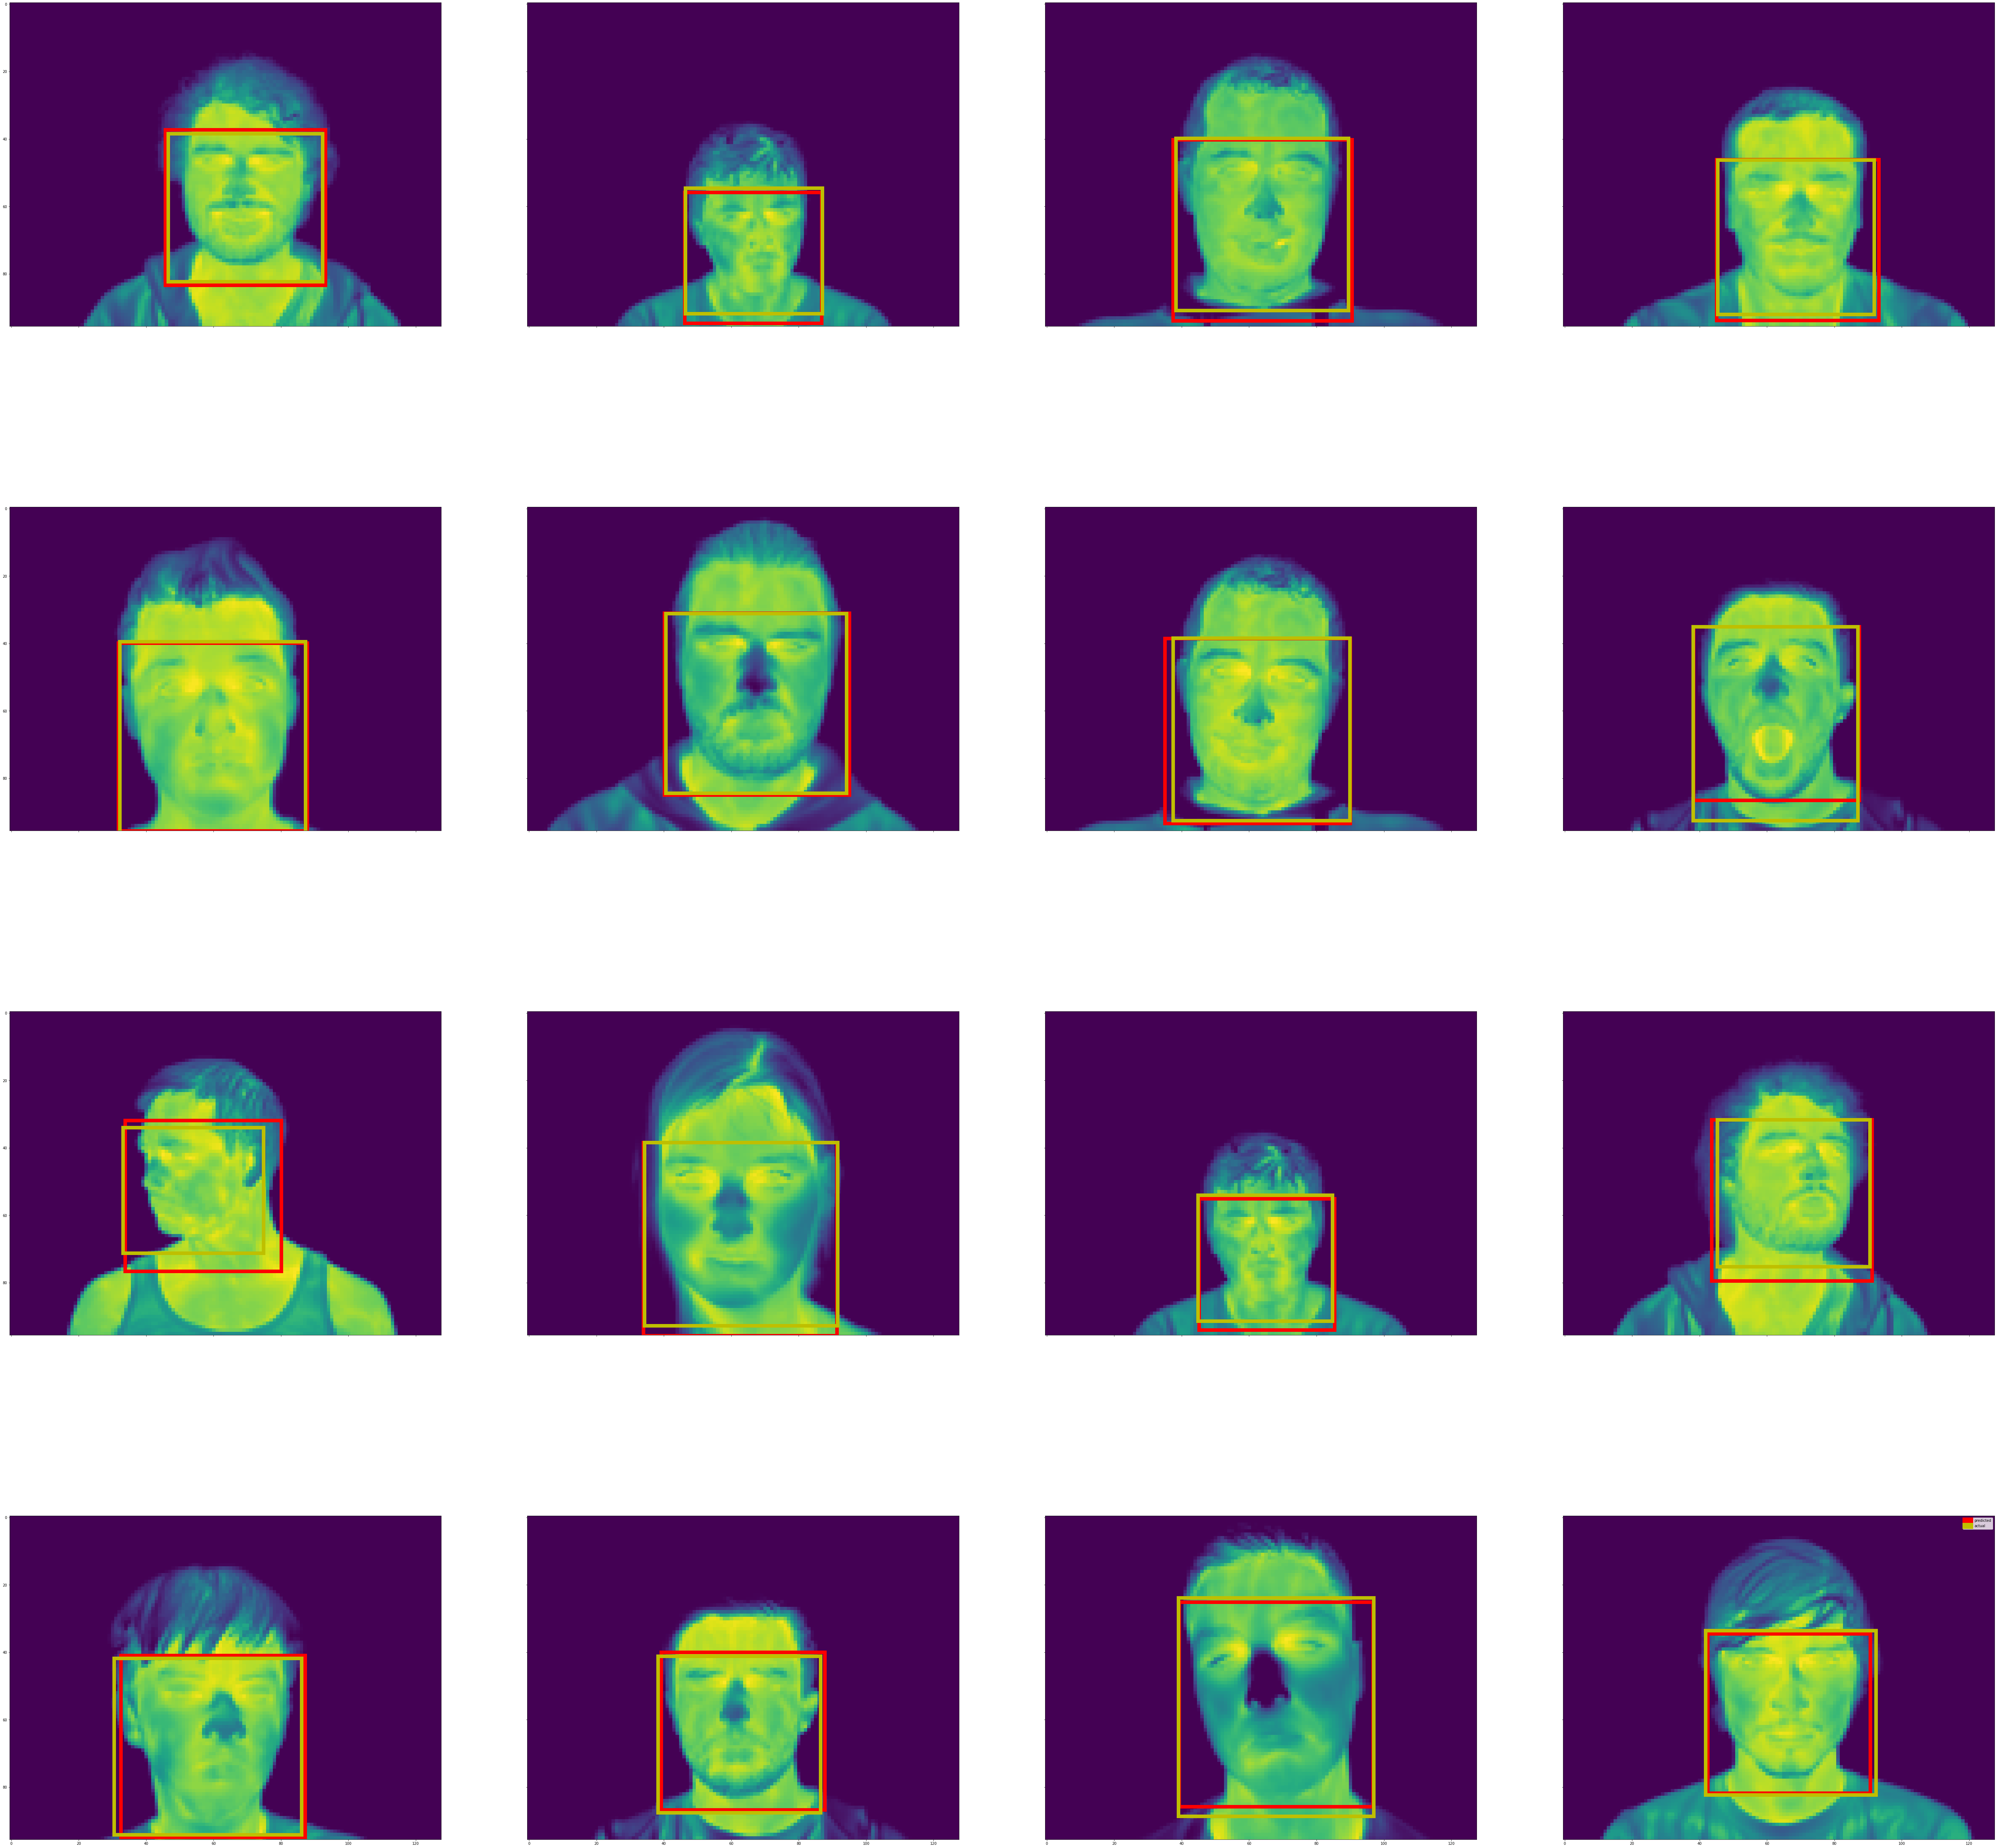

In [ ]:
import tensorflow.keras.losses



y_test_pred = model3.predict(test_x)
plot_predictions(y_test_pred)


This plot accuractly describes the model performance. It can be clearly seen that approximately 90% images have more intersection of union more than 0.8. Usually intersection of union >= 0.5 is considered a successful, while in our case, we have iou >= 0.8 for 90% of images.

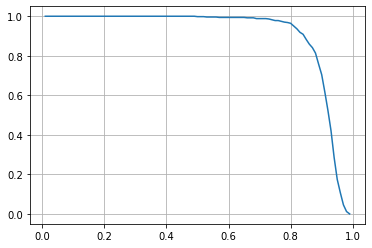

tf.Tensor(0.011708189733326435, shape=(), dtype=float64)
tf.Tensor(1.248192548751831, shape=(), dtype=float64)


In [ ]:



predictions = np.zeros((y_test_pred.shape))
actual = np.zeros((test_y.shape))
predictions[:, 0], predictions[:, 1] = y_test_pred[:, 0] * SIZE_X, y_test_pred[:, 1] * SIZE_X
actual[:,0], actual[:, 1] = test_y[:,0] * SIZE_X, test_y[:, 1] * SIZE_X

predictions[:, 2], predictions[:, 3] = y_test_pred[:, 2] * SIZE_Y, y_test_pred[:, 3] * SIZE_Y
actual[:,2], actual[:, 3] = test_y[:,2] * SIZE_Y, test_y[:, 3] * SIZE_Y

intersection_over_union_set(actual, predictions)

mse = tensorflow.keras.losses.MeanAbsoluteError()
print(mse(y_test_pred, test_y))
print(mse(predictions, actual))

In [ ]:
model3.save_weights('/content/drive/My Drive/thermal/modelnew_augmentedData_best.h5')